# Paillier Crypto

## Load Public Key

In [1]:
import torch
import os

if not os.path.isfile('/tmp/public.key'):
    raise FileNotFoundError("Public Key is not found. Generate it using the `paillier_crypto_server` script.")
else:
    public_key = torch.load('/tmp/public.key')
    print("Load public key from /tmp/public.key")
    print(public_key)

Load public key from /tmp/public.key
<OpenFed> PublicKey
n_lwe: 3000, bits: 32, bits_safe: 24, l: 64, bound: 8, p: 4294967297, q: 4294967296



## Download Dataset

In [2]:
from openfed.data import IIDPartitioner, PartitionerDataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

dataset = PartitionerDataset(
    MNIST(r'/tmp/', True, ToTensor(), download=True), total_parts=10, partitioner=IIDPartitioner())

## Dataloader

In [3]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0, drop_last=False)

## Network

In [4]:
import torch.nn as nn

network = nn.Linear(784, 10)
loss_fn = nn.CrossEntropyLoss()

## Build Optimizer

In [5]:
import torch

from openfed.optim import build_fed_optim

optim = torch.optim.SGD(network.parameters(), lr=0.1)
fed_optim = build_fed_optim(optim)

print(fed_optim)

<OpenFed> Gluer
Gluer_SGD_Penalizer



## Topology

In [6]:
import openfed

server_node = openfed.topo.Node('server', openfed.default_tcp_address, mtt=5)
client = openfed.topo.Node('client', openfed.empty_address, mtt=5)

topology = openfed.topo.Topology()
topology.add_edge(client, server_node)

federated_group_props = topology.analysis(client)[0]

print(federated_group_props)


openfed_follower, client, mtt=5
Address(backend='gloo', init_method='tcp://localhost:1994', world_size=2, rank=1)


## API

In [7]:
from openfed import API

openfed_api = API(
    state_dict=network.state_dict(keep_vars=True),
    fed_optim=fed_optim)

print(openfed_api)

## Paillier Crypto Hook

In [8]:
from openfed.hooks import PaillierCrypto

with openfed_api:
    paillier_crypto = PaillierCrypto(public_key)
    print(paillier_crypto)

## Connection

In [9]:
openfed_api.build_connection(federated_group_props)

## Train Loop

In [10]:
import random
import time

version = 0
outter_losses = []
for outter in range(5):
    outter_loss = []
    for inner in range(2):
        openfed_api.update_version(version)
        openfed_api.step(upload=False)
        
        part_id = random.randint(0, 9)
        print(f"Select part_id={part_id}")
        dataset.set_part_id(part_id)
        
        network.train()
        losses = []
        tic = time.time()
        for data in dataloader:
            x, y = data
            output = network(x.view(-1, 784))
            loss = loss_fn(output, y)

            fed_optim.zero_grad()
            loss.backward()
            fed_optim.step()
            losses.append(loss.item())
        toc = time.time()
        loss = sum(losses)/len(losses)
        duration = toc-tic

        fed_optim.round()

        openfed_api.update_version(version + 1)
        openfed_api.step(download=False)
        fed_optim.clear_buffer()
        outter_loss.append(loss)
        print(f"Outter: {outter}, Inner: {inner}, version: {version}, loss: {loss:.2f}, duration: {duration:.2f}")
    version += 1
    outter_losses.append(sum(outter_loss) / len(outter_loss))
print("Finished.")

Select part_id=4
Outter: 0, Inner: 0, version: 0, loss: 0.57, duration: 0.69
Select part_id=3
Outter: 0, Inner: 1, version: 0, loss: 0.55, duration: 0.63
Select part_id=2
Outter: 1, Inner: 0, version: 1, loss: 0.42, duration: 0.76
Select part_id=9
Outter: 1, Inner: 1, version: 1, loss: 0.31, duration: 0.78
Select part_id=2
Outter: 2, Inner: 0, version: 2, loss: 0.37, duration: 0.77
Select part_id=7
Outter: 2, Inner: 1, version: 2, loss: 0.38, duration: 0.72
Select part_id=9
Outter: 3, Inner: 0, version: 3, loss: 0.27, duration: 0.64
Select part_id=1
Outter: 3, Inner: 1, version: 3, loss: 0.34, duration: 0.62
Select part_id=2
Outter: 4, Inner: 0, version: 4, loss: 0.34, duration: 0.65
Select part_id=0
Outter: 4, Inner: 1, version: 4, loss: 0.31, duration: 0.68
Finished.


## Loss

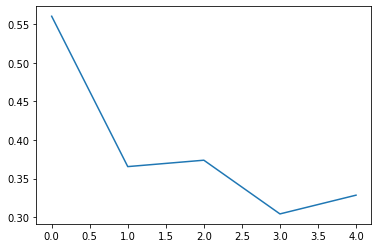

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()
plt.plot(outter_losses)
plt.show()